In [3]:
import numpy as np
import h5py as h5
from nbodykit.lab import *
import matplotlib.pyplot as plt
plt.style.use('Minh_paper_style')
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)

## Check the data box

In [7]:
cat_origin='../A_mock_real-space.h5'

with h5.File(cat_origin,'r') as fhandle:
    galaxies = fhandle['galaxies']
    x = galaxies['x'] #each in units of comoving-Mpc/h
    y = galaxies['y']
    z = galaxies['z']
    
print(x.max())
print(y.max())
print(z.max())

1099.9983
1099.9984
1099.9952


## Specify setup

In [38]:
cat_processed='../LEFTFIED_input/A_mock_real-space_real_NGEul192.h5'
Lbox=1100.

## Read in original galaxy catalog and compute auto-power using nbodykit

In [39]:
cat=HDFCatalog(cat_origin)
cat['Position']=x[:,None]*(1,0,0)+y[:,None]*(0,1,0)+z[:,None]*(0,0,1)
cat.attrs['BoxSize']=1100.
mesh_origin = cat.to_mesh(resampler='cic', Nmesh=192, compensated=False, interlaced=False, position='Position')
r_origin = FFTPower(mesh_origin, mode='1d', dk=0.005, kmin=0.005)
Pk_origin = r_origin.power
for k in Pk.attrs:
    print("%s = %s" %(k, str(Pk.attrs[k])))

Nmesh = [256 256 256]
BoxSize = [1100. 1100. 1100.]
Lx = 1100.0
Ly = 1100.0
Lz = 1100.0
volume = 1331000000.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.005
kmin = 0.005
kmax = None
N1 = 531401
N2 = 531401
shotnoise = 2504.69984061001


## Read in lefty-input galaxy catalog and compute auto-power

In [40]:
with h5.File(cat_processed, 'r') as fhandle:
    delta=fhandle['real'][()]
    print(delta.shape)
mesh_leftfield = ArrayMesh(delta,BoxSize=Lbox)
r_leftfield = FFTPower(mesh_leftfield, mode='1d', dk=0.005, kmin=0.005)
Pk_leftfield = r_leftfield.power
for k in Pk.attrs:
    print("%s = %s" %(k, str(Pk.attrs[k])))

(192, 192, 192)
Nmesh = [256 256 256]
BoxSize = [1100. 1100. 1100.]
Lx = 1100.0
Ly = 1100.0
Lz = 1100.0
volume = 1331000000.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.005
kmin = 0.005
kmax = None
N1 = 531401
N2 = 531401
shotnoise = 2504.69984061001


## Get $P_{\mathrm{lin}}$ from CAMB to compare with the other two

In [25]:
redshift = 1.0
Omega0_m=0.3111
Omega0_b=0.04897468161869667
Omega0_cdm=Omega0_m-Omega0_b
h=0.6766
sigma8=0.8102
n_s=0.9665
cosmo = cosmology.Cosmology(h=h,Omega0_cdm=Omega0_cdm,Omega0_b=Omega0_b,m_ncdm=[],sigma8=sigma8,n_s=n_s)
Plin_CLASS = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
Pnonlin_Zeldovich = cosmology.ZeldovichPower(cosmo, redshift)
Pnonlin_HALOFIT = cosmology.HalofitPower(cosmo, redshift)

/u/minh/conda-envs/jupyterlab-env/lib/python3.6/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


## Plot power spectra

(0.01, 0.6)

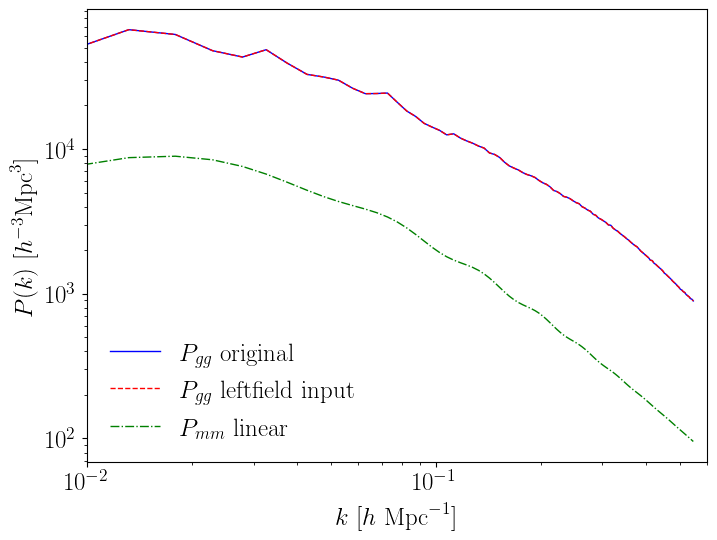

In [41]:
# print the shot noise subtracted P(k)
plt.loglog(Pk_origin['k'], Pk_origin['power'].real, c='b',label=r'$P_{gg}$ original')
plt.loglog(Pk_leftfield['k'],Pk_leftfield['power'].real,c='r',ls='--',label=r'$P_{gg}$ leftfield input')
plt.loglog(Pk_origin['k'],Plin_CLASS(Pk_origin['k']),c='green',ls='-.',label=r'$P_{mm}$ linear')
#plt.loglog(Pk_origin['k'],Pnonlin_HALOFIT(Pk_origin['k']),c='violet',ls=':',label=r'$P_{mm}$ HALOFIT')

# format the axes
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

## Compute linear galaxy bias $b_1$

In [36]:
np.sqrt(Pk_leftfield['power'].real[Pk_leftfield['k']<0.02]/Plin_CLASS(Pk_origin['k'][Pk_leftfield['k']<0.02]))

array([2.47124368, 2.76780899, 2.63421143])